In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

In [3]:
BASE_PATH = "/mnt/Data/data"
base_dir = Path(BASE_PATH).resolve()

In [4]:
config = {
    "config_folder": "../data/mearec",
    "recordings_folder": str(base_dir / "output/recordings"),
    "templates_folder": str(base_dir / "output/templates"),
}
output_base="output"
preprocessor="preprocessor"
evaluator="evaluator"
lcadc_suffix={
    True:"_lcadc",
    False:""
}
ul_suffix={
    6000:"",
    3000:"-bw-300-3000",
    1000:"-bw-300-1000"
}

def build_neo_folder(is_lcadc, bw):
    return str(base_dir / "".join([output_base,ul_suffix[bw]]) / "".join([preprocessor,lcadc_suffix[is_lcadc]]))

def build_eval_folder(is_lcadc, bw):
    return str(base_dir / "".join([output_base,ul_suffix[bw]]) / "".join([evaluator,lcadc_suffix[is_lcadc]]))


In [5]:
from eapprocessor.tools.load import load_neo

In [6]:
fs_list = [20000]
noise_levels = [5, 25]
resolution_list = [6,7,8]
bw_list =[1000,6000]
w=4
channel=27
spiketrain_idx=8
is_lcadc_list=[True, False]

In [7]:
def wrapper_load_neo(fs,noise_level,resolution,bw,is_lcadc):
    return load_neo(build_neo_folder(is_lcadc,bw),
                    resolution=resolution,
                    noise_level=noise_level,
                    fs=fs,
                    is_lcadc=is_lcadc)


In [8]:
import itertools

In [9]:
results=[]
for fs, noise_level, resolution, bw, is_lcadc in itertools.product(fs_list, noise_levels, 
                                                             resolution_list, bw_list, is_lcadc_list):
    results.append([fs, noise_level, resolution, bw, is_lcadc,
                    wrapper_load_neo(fs, noise_level,resolution,bw,is_lcadc)])

Search for pattern: *_6_5uV_20000Hz*
Loading file /mnt/Data/data/output-bw-300-1000/preprocessor_lcadc/preprocessed_neo_6_5uV_20000Hz_2022-08-08_13-49.h5
Search for pattern: *_6_5uV_20000Hz*
Loading file /mnt/Data/data/output-bw-300-1000/preprocessor/preprocessed_neo_6_5uV_20000Hz_2022-08-08_09-49.h5
Search for pattern: *_6_5uV_20000Hz*
Loading file /mnt/Data/data/output/preprocessor_lcadc/preprocessed_neo_6_5uV_20000Hz_2022-08-08_11-09.h5
Search for pattern: *_6_5uV_20000Hz*
Loading file /mnt/Data/data/output/preprocessor/preprocessed_neo_6_5uV_20000Hz_2022-08-08_09-15.h5
Search for pattern: *_7_5uV_20000Hz*
Loading file /mnt/Data/data/output-bw-300-1000/preprocessor_lcadc/preprocessed_neo_7_5uV_20000Hz_2022-08-08_13-40.h5
Search for pattern: *_7_5uV_20000Hz*
Loading file /mnt/Data/data/output-bw-300-1000/preprocessor/preprocessed_neo_7_5uV_20000Hz_2022-08-08_09-47.h5
Search for pattern: *_7_5uV_20000Hz*
Loading file /mnt/Data/data/output/preprocessor_lcadc/preprocessed_neo_7_5uV_2000

In [10]:
import pandas as pd
import numpy as np

In [11]:
df=pd.DataFrame(results, columns=["fs", "noise_level", "resolution", "bw", "is_lcadc", "result"])

In [12]:
df[["neo_obj", "neo_file"]]=pd.DataFrame(df["result"].tolist())
df.drop(columns=["result"],inplace=True)
df.head()

,fs,noise_level,resolution,bw,is_lcadc,neo_obj,neo_file
0,20000,5,6,1000,True,"{'adcinfo': {'resolution': 6, 'voltage_ref': 5...",/mnt/Data/data/output-bw-300-1000/preprocessor...
1,20000,5,6,1000,False,"{'adcinfo': {'resolution': 6, 'voltage_ref': 5...",/mnt/Data/data/output-bw-300-1000/preprocessor...
2,20000,5,6,6000,True,"{'adcinfo': {'resolution': 6, 'voltage_ref': 5...",/mnt/Data/data/output/preprocessor_lcadc/prepr...
3,20000,5,6,6000,False,"{'adcinfo': {'resolution': 6, 'voltage_ref': 5...",/mnt/Data/data/output/preprocessor/preprocesse...
4,20000,5,7,1000,True,"{'adcinfo': {'resolution': 7, 'voltage_ref': 5...",/mnt/Data/data/output-bw-300-1000/preprocessor...


In [13]:
import h5py
import MEArec
import math

In [14]:
def from_group_to_array(group):
    a=[[]]*len(group)
    for item in group:
        if isinstance(group[item], h5py._hl.dataset.Dataset):
            a[int(item)]=np.array(group[item])
        elif isinstance(group[item], h5py._hl.group.Group):
            a[int(item)]=from_group_to_array(group[item])
        
    return np.array(a,dtype=object)

def parse_rec_obj(rec_obj):
    return {
        "recordings": np.array(rec_obj.recordings).T,
        "spiketrains": rec_obj.spiketrains,
        "timestamps": np.array(rec_obj.timestamps)
    }


def parse_neo_obj(neo_obj):
    for key,val in neo_obj.items():
        #print(type(val))
        if isinstance(val, h5py._hl.dataset.Dataset):
            neo_obj[key]=np.array(val)
        elif isinstance(val, h5py._hl.group.Group):
            neo_obj[key]=from_group_to_array(val)
        elif isinstance(val, MEArec.generators.recordinggenerator.RecordingGenerator):
            neo_obj[key]=parse_rec_obj(val)
        
    return neo_obj

def obj_to_series(neo_obj):
    return pd.Series(parse_neo_obj(neo_obj))

In [15]:
ex=df["neo_obj"][0]
obj_to_series(ex)["recordings"]

{'recordings': array([[-7.2311153e+00, -2.7587960e+00, -2.3247678e+00, ...,
         -1.3574948e+00,  1.7728448e+00,  8.1556301e+00],
        [-1.1059606e+00, -6.4278569e+00,  1.8609204e+00, ...,
         -1.7591453e-01,  2.3866336e+00,  2.2236352e+00],
        [-4.0286905e-01, -1.6020525e+01,  3.1713166e+00, ...,
          1.0707998e+00, -3.0986516e+00,  8.7994337e-02],
        ...,
        [-2.9521513e+00,  1.7604921e+00,  6.8484459e+00, ...,
          5.5886769e+00, -2.0498977e+00,  1.0679415e+01],
        [-1.2358111e+00, -4.5244908e+00, -7.5556040e-03, ...,
          1.0344363e+01,  8.0520868e-02,  5.7061779e-01],
        [ 8.9501562e+00,  9.3797998e+00, -5.2109289e+00, ...,
         -5.0103865e+00, -2.5175805e+00,  1.7744868e+00]], dtype=float32),
 'spiketrains': [SpikeTrain
  annotations: {'bintype': 'E',
    'bursting': False,
    'cell_type': 'E',
    'exp_decay': None,
    'fr': 3.2502345269453023,
    'max_burst_duration': None,
    'max_spikes_per_burst': None,
    'mtype':

In [16]:
ex["recordings"]

{'recordings': array([[-7.2311153e+00, -2.7587960e+00, -2.3247678e+00, ...,
         -1.3574948e+00,  1.7728448e+00,  8.1556301e+00],
        [-1.1059606e+00, -6.4278569e+00,  1.8609204e+00, ...,
         -1.7591453e-01,  2.3866336e+00,  2.2236352e+00],
        [-4.0286905e-01, -1.6020525e+01,  3.1713166e+00, ...,
          1.0707998e+00, -3.0986516e+00,  8.7994337e-02],
        ...,
        [-2.9521513e+00,  1.7604921e+00,  6.8484459e+00, ...,
          5.5886769e+00, -2.0498977e+00,  1.0679415e+01],
        [-1.2358111e+00, -4.5244908e+00, -7.5556040e-03, ...,
          1.0344363e+01,  8.0520868e-02,  5.7061779e-01],
        [ 8.9501562e+00,  9.3797998e+00, -5.2109289e+00, ...,
         -5.0103865e+00, -2.5175805e+00,  1.7744868e+00]], dtype=float32),
 'spiketrains': [SpikeTrain
  annotations: {'bintype': 'E',
    'bursting': False,
    'cell_type': 'E',
    'exp_decay': None,
    'fr': 3.2502345269453023,
    'max_burst_duration': None,
    'max_spikes_per_burst': None,
    'mtype':

In [17]:
neodf=df["neo_obj"].apply(obj_to_series)
neodf.head()

,adcinfo,channels,lcadc,indexes,normalized,recordings,w,neo,adc
0,"{'resolution': 6, 'voltage_ref': 500}","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[32, 31, 32, 31, 32, 33, 35, 34, 33, 31, 29, ...","[[0, 374, 381, 495, 508, 518, 528, 531, 534, 5...","[[0.0, -0.03125, 0.0, -0.03125, 0.0, 0.03125, ...","{'recordings': [[-7.2311153, -2.758796, -2.324...","[1, 4, 16, 32]","[[[0.0, 0.0009765625, -0.0009765625, 0.0009765...",NaN
1,"{'resolution': 6, 'voltage_ref': 500}",NaN,NaN,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, ...","{'recordings': [[-7.2311153, -2.758796, -2.324...","[1, 4, 16, 32]","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000976...","[[32, 32, 32, 32, 32, 32, 32, 33, 32, 32, 32, ..."
2,"{'resolution': 6, 'voltage_ref': 500}","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[32, 33, 32, 31, 32, 31, 32, 33, 32, 31, 32, ...","[[0, 14, 17, 38, 39, 51, 53, 82, 84, 106, 109,...","[[0.0, 0.03125, 0.0, -0.03125, 0.0, -0.03125, ...","{'recordings': [[-6.97424, -1.6472181, 1.96873...","[1, 4, 16, 32]","[[[0.0, 0.0009765625, 0.0009765625, 0.00097656...",NaN
3,"{'resolution': 6, 'voltage_ref': 500}",NaN,NaN,NaN,"[[0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.03125, 0...","{'recordings': [[-6.97424, -1.6472181, 1.96873...","[1, 4, 16, 32]","[[[0.0, 0.0, 0.0, 0.0009765625, 0.0, 0.0, 0.00...","[[32, 32, 32, 33, 32, 32, 33, 33, 32, 32, 32, ..."
4,"{'resolution': 7, 'voltage_ref': 500}","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[63, 65, 64, 65, 64, 65, 63, 65, 63, 65, 63, ...","[[0, 3, 4, 7, 9, 11, 12, 13, 17, 18, 19, 20, 2...","[[-0.015625, 0.015625, 0.0, 0.015625, 0.0, 0.0...","{'recordings': [[-7.2311153, -2.758796, -2.324...","[1, 4, 16, 32]","[[[-0.015625, 0.000244140625, -0.000244140625,...",NaN


In [18]:
def filter_list(arr, idx):
    if isinstance(arr,(list,np.ndarray)):
        return arr[idx];
    return arr

def filter_neo_df(row,channel,w):
    w_idx = np.where(row["w"]==w)[0][0]
    row["neo"]=row["neo"][w_idx]
    for col in ["lcadc", "indexes","normalized","adc","neo"]:
        row[col] = filter_list(row[col],channel)
    row["w"]=w
    row["channels"]=channel
    return row

In [19]:
neodf=df["neo_obj"].apply(obj_to_series)
neodf.apply(lambda x: filter_neo_df(x,channel,w),axis=1)
neodf.drop(columns=["lcadc","adc"],inplace=True)
neodf.head()

,adcinfo,channels,indexes,normalized,recordings,w,neo
0,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...","{'recordings': [[-7.2311153, -2.758796, -2.324...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0...."
1,"{'resolution': 6, 'voltage_ref': 500}",27,NaN,"[0.0, 0.0, 0.0, -0.03125, -0.03125, 0.0, 0.0, ...","{'recordings': [[-7.2311153, -2.758796, -2.324...",4,"[0.0, 0.0, 0.0, -0.03125, 0.0009765625, 0.0, 0..."
2,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 3, 5, 14, 16, 17, 33, 34, 62, 65, 68, 72, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, 0.0, -...","{'recordings': [[-6.97424, -1.6472181, 1.96873...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0...."
3,"{'resolution': 6, 'voltage_ref': 500}",27,NaN,"[0.0, 0.03125, 0.0, -0.03125, -0.03125, 0.0, 0...","{'recordings': [[-6.97424, -1.6472181, 1.96873...",4,"[0.0, 0.03125, 0.0, -0.03125, 0.0009765625, 0...."
4,"{'resolution': 7, 'voltage_ref': 500}",27,"[0, 3, 5, 8, 14, 16, 33, 34, 58, 62, 63, 68, 6...","[0.0, -0.03125, 0.0, -0.015625, 0.015625, 0.0,...","{'recordings': [[-7.2311153, -2.758796, -2.324...",4,"[0.0, -0.03125, 0.0, -0.015625, 0.000244140625..."


In [20]:
ndf=df.assign(**neodf).drop(columns=["neo_obj"])
ndf.head()

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,recordings,w,neo
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...","{'recordings': [[-7.2311153, -2.758796, -2.324...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0...."
1,20000,5,6,1000,False,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,NaN,"[0.0, 0.0, 0.0, -0.03125, -0.03125, 0.0, 0.0, ...","{'recordings': [[-7.2311153, -2.758796, -2.324...",4,"[0.0, 0.0, 0.0, -0.03125, 0.0009765625, 0.0, 0..."
2,20000,5,6,6000,True,/mnt/Data/data/output/preprocessor_lcadc/prepr...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 3, 5, 14, 16, 17, 33, 34, 62, 65, 68, 72, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, 0.0, -...","{'recordings': [[-6.97424, -1.6472181, 1.96873...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0...."
3,20000,5,6,6000,False,/mnt/Data/data/output/preprocessor/preprocesse...,"{'resolution': 6, 'voltage_ref': 500}",27,NaN,"[0.0, 0.03125, 0.0, -0.03125, -0.03125, 0.0, 0...","{'recordings': [[-6.97424, -1.6472181, 1.96873...",4,"[0.0, 0.03125, 0.0, -0.03125, 0.0009765625, 0...."
4,20000,5,7,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 7, 'voltage_ref': 500}",27,"[0, 3, 5, 8, 14, 16, 33, 34, 58, 62, 63, 68, 6...","[0.0, -0.03125, 0.0, -0.015625, 0.015625, 0.0,...","{'recordings': [[-7.2311153, -2.758796, -2.324...",4,"[0.0, -0.03125, 0.0, -0.015625, 0.000244140625..."


In [21]:
def filter_rec_df(row,channel,spiketrain_idx):
    row["spiketrains"]=row["spiketrains"][spiketrain_idx]
    row["recordings"]=row["recordings"][channel]
    return row

In [22]:
recdf=ndf["recordings"].apply(pd.Series)
recdf.apply(lambda x: filter_rec_df(x,channel,spiketrain_idx),axis=1)
recdf.head()

,recordings,spiketrains,timestamps
0,"[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,..."
1,"[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,..."
2,"[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,..."
3,"[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,..."
4,"[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,..."


In [23]:
nndf=ndf.drop(columns=["recordings"]).assign(**recdf)
nndf.head()

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,w,neo,recordings,spiketrains,timestamps
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,..."
1,20000,5,6,1000,False,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,NaN,"[0.0, 0.0, 0.0, -0.03125, -0.03125, 0.0, 0.0, ...",4,"[0.0, 0.0, 0.0, -0.03125, 0.0009765625, 0.0, 0...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,..."
2,20000,5,6,6000,True,/mnt/Data/data/output/preprocessor_lcadc/prepr...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 3, 5, 14, 16, 17, 33, 34, 62, 65, 68, 72, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, 0.0, -...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,..."
3,20000,5,6,6000,False,/mnt/Data/data/output/preprocessor/preprocesse...,"{'resolution': 6, 'voltage_ref': 500}",27,NaN,"[0.0, 0.03125, 0.0, -0.03125, -0.03125, 0.0, 0...",4,"[0.0, 0.03125, 0.0, -0.03125, 0.0009765625, 0....","[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,..."
4,20000,5,7,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 7, 'voltage_ref': 500}",27,"[0, 3, 5, 8, 14, 16, 33, 34, 58, 62, 63, 68, 6...","[0.0, -0.03125, 0.0, -0.015625, 0.015625, 0.0,...",4,"[0.0, -0.03125, 0.0, -0.015625, 0.000244140625...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,..."


In [24]:
np.array(nndf["spiketrains"][0])

array([0.04302219, 0.09141616, 0.13770031, 0.24237551, 0.27664213,
       0.37804019, 0.51500822, 0.52655147, 0.59275611, 0.64264463,
       0.95683937, 0.96283024, 1.04895815, 1.07106541, 1.43739366,
       1.46774967, 1.47418014, 1.75754472, 1.80275632, 1.84835809,
       1.90016827, 2.09876206, 2.14551569, 2.14763561, 2.33754158,
       2.43285197, 2.52368504, 2.53139357, 2.63191922, 2.71719007,
       2.89443896, 2.94373778, 3.03001957, 3.17195324, 3.21098454,
       3.25725345, 3.26628734, 3.28089017, 3.34433759, 3.36886256,
       3.38284091, 3.43129189, 3.63980888, 3.65815215, 3.75125045,
       3.85062358, 3.95128354, 4.13030615, 4.15731659, 4.23604266,
       4.24910607, 4.33478013, 4.38134619, 4.42176159, 4.49383208,
       4.53893606, 4.64416471, 4.70165132, 4.8327213 , 4.86072926,
       4.94135792, 4.9671027 , 5.04201875, 5.07234758, 5.07673192,
       5.11739449, 5.20277141, 5.22339453, 5.29014328, 5.29912931,
       5.36940928, 5.37357099, 5.37695217, 5.42665772, 5.45130

In [25]:
breakpoints_file = str(base_dir / "breakpoints.csv")

In [26]:
bdf=pd.read_csv(breakpoints_file)
bdf["chunk_idx"]=bdf.index
bdf

,l_limit_idx,h_limit_idx,l_limit,h_limit,chunk_idx
0,0,19982,0.00000,0.99910,0
1,19983,39979,0.99915,1.99895,1
2,39980,59873,1.99900,2.99365,2
3,59874,79974,2.99370,3.99870,3
4,79975,99914,3.99875,4.99570,4
5,99915,119995,4.99575,5.99975,5
6,119996,139756,5.99980,6.98780,6
7,139757,160047,6.98785,8.00235,7
8,160048,179914,8.00240,8.99570,8
9,179915,199999,8.99575,9.99995,9


In [27]:
edf=nndf.merge(bdf, how='cross')
edf.head()

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,w,neo,recordings,spiketrains,timestamps,l_limit_idx,h_limit_idx,l_limit,h_limit,chunk_idx
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.00000,0.99910,0
1,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",19983,39979,0.99915,1.99895,1
2,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",39980,59873,1.99900,2.99365,2
3,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",59874,79974,2.99370,3.99870,3
4,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",4,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",79975,99914,3.99875,4.99570,4


In [28]:
edf["spiketrain_chunk"]=edf.apply(lambda x: 
                                  x["spiketrains"][(x["spiketrains"]> x["l_limit"])&
                                                   (x["spiketrains"]<= x["h_limit"])], axis=1)
edf

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,...,neo,recordings,spiketrains,timestamps,l_limit_idx,h_limit_idx,l_limit,h_limit,chunk_idx,spiketrain_chunk
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.00000,0.99910,0,"[0.043022192914784686 s, 0.09141615511014173 s..."
1,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",19983,39979,0.99915,1.99895,1,"[1.0489581465556497 s, 1.0710654084903757 s, 1..."
2,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",39980,59873,1.99900,2.99365,2,"[2.098762063079152 s, 2.145515693894677 s, 2.1..."
3,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",59874,79974,2.99370,3.99870,3,"[3.030019569592036 s, 3.1719532393467604 s, 3...."
4,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",79975,99914,3.99875,4.99570,4,"[4.130306152649535 s, 4.157316593457093 s, 4.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,20000,25,8,6000,False,/mnt/Data/data/output/preprocessor/preprocesse...,"{'resolution': 8, 'voltage_ref': 500}",27,NaN,"[0.0234375, 0.1015625, 0.015625, -0.1953125, -...",...,"[0.0234375, 0.1015625, 0.015625, -0.1953125, 0...","[11.770864, 49.767525, 9.390785, -97.465225, -...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",99915,119995,4.99575,5.99975,5,"[5.042018754991749 s, 5.0723475816028225 s, 5...."
236,20000,25,8,6000,False,/mnt/Data/data/output/preprocessor/preprocesse...,"{'resolution': 8, 'voltage_ref': 500}",27,NaN,"[0.0234375, 0.1015625, 0.015625, -0.1953125, -...",...,"[0.0234375, 0.1015625, 0.015625, -0.1953125, 0...","[11.770864, 49.767525, 9.390785, -97.465225, -...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",119996,139756,5.99980,6.98780,6,"[6.06952606115295 s, 6.088285067358667 s, 6.21..."
237,20000,25,8,6000,False,/mnt/Data/data/output/preprocessor/preprocesse...,"{'resolution': 8, 'voltage_ref': 500}",27,NaN,"[0.0234375, 0.1015625, 0.015625, -0.1953125, -...",...,"[0.0234375, 0.1015625, 0.015625, -0.1

In [29]:
edf["recording_chunk"]=edf.apply(lambda x: 
                                  x["recordings"][x["l_limit_idx"]:x["h_limit_idx"]+1], axis=1)
edf.head()

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,...,recordings,spiketrains,timestamps,l_limit_idx,h_limit_idx,l_limit,h_limit,chunk_idx,spiketrain_chunk,recording_chunk
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.00000,0.99910,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ..."
1,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",19983,39979,0.99915,1.99895,1,"[1.0489581465556497 s, 1.0710654084903757 s, 1...","[-2.9933784, -0.6633488, -11.669907, 2.781744,..."
2,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",39980,59873,1.99900,2.99365,2,"[2.098762063079152 s, 2.145515693894677 s, 2.1...","[0.7094796, -0.18536192, 0.8696826, 4.3431587,..."
3,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",59874,79974,2.99370,3.99870,3,"[3.030019569592036 s, 3.1719532393467604 s, 3....","[-4.2250457, -0.7141621, -11.509712, -9.980713..."
4,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",79975,99914,3.99875,4.99570,4,"[4.130306152649535 s, 4.157316593457093 s, 4.2...","[3.4243042, 2.591824, 7.650317, 6.207827, 13.2..."


In [30]:
rec=edf.loc[(edf["chunk_idx"]==5)&(edf["noise_level"]==5)&(edf["bw"]==6000)].reset_index()["recording_chunk"][0]

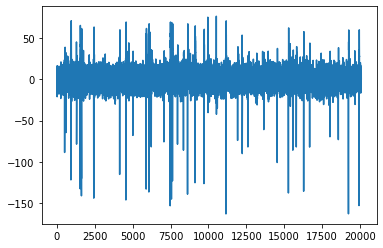

In [31]:
import matplotlib.pylab as plt
plt.plot(rec)

In [32]:
from eapprocessor.evaluator.spikes import estimate_sample_spikes, comparison_detection_spiketrain

In [33]:
fs_df = edf.drop_duplicates(subset=["fs"]).copy()
fs_df

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,...,recordings,spiketrains,timestamps,l_limit_idx,h_limit_idx,l_limit,h_limit,chunk_idx,spiketrain_chunk,recording_chunk
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ..."


In [34]:
fs_df["estimated_index"] = fs_df.apply(lambda x: estimate_sample_spikes(spikes= x["spiketrains"],
                                                                         timestamps=x["timestamps"]),
                                       axis=1)

In [35]:
fs_df[["spike_indexes", "err_list"]] = pd.DataFrame(fs_df["estimated_index"].tolist(), index=fs_df.index)
fs_df

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,...,l_limit_idx,h_limit_idx,l_limit,h_limit,chunk_idx,spiketrain_chunk,recording_chunk,estimated_index,spike_indexes,err_list
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [36]:
fs_df["spike_indexes"].apply(np.max)

0    1.0
Name: spike_indexes, dtype: float64

In [37]:
nedf = edf.join(fs_df.set_index("fs")["spike_indexes"], on="fs", how='left')
nedf.head()

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,...,spiketrains,timestamps,l_limit_idx,h_limit_idx,l_limit,h_limit,chunk_idx,spiketrain_chunk,recording_chunk,spike_indexes
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.00000,0.99910,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",19983,39979,0.99915,1.99895,1,"[1.0489581465556497 s, 1.0710654084903757 s, 1...","[-2.9933784, -0.6633488, -11.669907, 2.781744,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",39980,59873,1.99900,2.99365,2,"[2.098762063079152 s, 2.145515693894677 s, 2.1...","[0.7094796, -0.18536192, 0.8696826, 4.3431587,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",59874,79974,2.99370,3.99870,3,"[3.030019569592036 s, 3.1719532393467604 s, 3....","[-4.2250457, -0.7141621, -11.509712, -9.980713...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",79975,99914,3.99875,4.99570,4,"[4.130306152649535 s, 4.157316593457093 s, 4.2...","[3.4243042, 2.591824, 7.650317, 6.207827, 13.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Get evaluation files

In [38]:
from eapprocessor.tools.load import load_neo, load_count_evaluation, get_evaluation_files

In [39]:
neo_df = nedf.drop_duplicates(subset=["neo_file"]).copy()
neo_df

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,...,spiketrains,timestamps,l_limit_idx,h_limit_idx,l_limit,h_limit,chunk_idx,spiketrain_chunk,recording_chunk,spike_indexes
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,20000,5,6,1000,False,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,NaN,"[0.0, 0.0, 0.0, -0.03125, -0.03125, 0.0, 0.0, ...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20,20000,5,6,6000,True,/mnt/Data/data/output/preprocessor_lcadc/prepr...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 3, 5, 14, 16, 17, 33, 34, 62, 65, 68, 72, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, 0.0, -...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
30,20000,5,6,6000,False,/mnt/Data/data/output/preprocessor/preprocesse...,"{'resolution': 6, 'voltage_ref': 500}",27,NaN,"[0.0, 0.03125, 0.0, -0.03125, -0.03125, 0.0, 0...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
40,20000,5,7,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 7, 'voltage_ref': 500}",27,"[0, 3, 5, 8, 14, 16, 33, 34, 58, 62, 63, 68, 6...","[0.0, -0.03125, 0.0, -0.015625, 0.015625, 0.0,...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
50,20000,5,7,1000,False,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 7, 'voltage_ref': 500}",27,NaN,"[0.0, 0.015625, 0.0, -0.03125, -0.015625, 0.0,...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
60,20000,5,7,6000,True,/mnt/Data/data/output/preprocessor_lcadc/prepr...,"{'resolution': 7, 'voltage_ref': 500}",27,"[0, 1, 3, 5, 7, 13, 14, 15, 16, 17, 18, 20, 23...","[0.0, 0.015625, -0.03125, 0.015625, -0.015625,...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
70,20000,5,7,6000,False,/mnt/Data/data/output/preprocessor/preprocesse...,"{'resolution': 7, 'voltage_ref': 500}",27,NaN,"[0.0, 0.015625, 0.0, -0.03125, -0.03125, 0.015...",...,"[0.043022192914784686 s, 0.09141615511014173 s...","[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[2.3110626, 9.914375, 1.8437628, -19.521925,

In [40]:
neo_df["evaluation_files"]=neo_df.apply(lambda x: get_evaluation_files(
    build_eval_folder(x["is_lcadc"], x["bw"]),
    sourcefile=x["neo_file"]), axis=1)
neo_df

Search for pattern: *
Filename found 3 files with source /mnt/Data/data/output-bw-300-1000/preprocessor_lcadc/preprocessed_neo_6_5uV_20000Hz_2022-08-08_13-49.h5
[PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5')]
Search for pattern: *
Filename found 3 files with source /mnt/Data/data/output-bw-300-1000/preprocessor/preprocessed_neo_6_5uV_20000Hz_2022-08-08_09-49.h5
[PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_17-01.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_17-01.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/e

Filename found 3 files with source /mnt/Data/data/output-bw-300-1000/preprocessor_lcadc/preprocessed_neo_7_25uV_20000Hz_2022-08-08_13-43.h5
[PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5')]
Search for pattern: *
Filename found 3 files with source /mnt/Data/data/output-bw-300-1000/preprocessor/preprocessed_neo_7_25uV_20000Hz_2022-08-08_09-48.h5
[PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_16-56.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_16-56.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator/thresh

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,...,timestamps,l_limit_idx,h_limit_idx,l_limit,h_limit,chunk_idx,spiketrain_chunk,recording_chunk,spike_indexes,evaluation_files
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output-bw-3...
10,20000,5,6,1000,False,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,NaN,"[0.0, 0.0, 0.0, -0.03125, -0.03125, 0.0, 0.0, ...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output-bw-3...
20,20000,5,6,6000,True,/mnt/Data/data/output/preprocessor_lcadc/prepr...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 3, 5, 14, 16, 17, 33, 34, 62, 65, 68, 72, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, 0.0, -...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output/eval...
30,20000,5,6,6000,False,/mnt/Data/data/output/preprocessor/preprocesse...,"{'resolution': 6, 'voltage_ref': 500}",27,NaN,"[0.0, 0.03125, 0.0, -0.03125, -0.03125, 0.0, 0...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output/eval...
40,20000,5,7,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 7, 'voltage_ref': 500}",27,"[0, 3, 5, 8, 14, 16, 33, 34, 58, 62, 63, 68, 6...","[0.0, -0.03125, 0.0, -0.015625, 0.015625, 0.0,...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output-bw-3...
50,20000,5,7,1000,False,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 7, 'voltage_ref': 500}",27,NaN,"[0.0, 0.015625, 0.0, -0.03125, -0.015625, 0.0,...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output-bw-3...
60,20000,5,7,6000,True,/mnt/Data/data/output/preprocessor_lcadc/prepr...,"{'resolution': 7, 'voltage_ref': 500}",27,"[0, 1, 3, 5, 7, 13, 14, 15, 16, 17, 18, 20, 23...","[0.0, 0.015625, -0.03125, 0.015625, -0.015625,...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output/eval...
70,20000,5,7,6000,False,/mnt/Data/data/output/preprocessor/preprocesse...,"{'resolution': 7, 'voltage_ref': 500}",27,NaN,"[0.0, 0.015625, 0.0, -0.03125, -0.03125, 0.015...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.0,0.9991,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[2.3110626, 9.914375, 1.8437628, -19.521925, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'

In [52]:
eedf = nedf.join(neo_df.set_index("neo_file")["evaluation_files"], on="neo_file", how='left')
eedf.head()

,fs,noise_level,resolution,bw,is_lcadc,neo_file,adcinfo,channels,indexes,normalized,...,timestamps,l_limit_idx,h_limit_idx,l_limit,h_limit,chunk_idx,spiketrain_chunk,recording_chunk,spike_indexes,evaluation_files
0,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",0,19982,0.00000,0.99910,0,"[0.043022192914784686 s, 0.09141615511014173 s...","[1.8704262, 4.2087336, 1.1238697, -12.036142, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output-bw-3...
1,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",19983,39979,0.99915,1.99895,1,"[1.0489581465556497 s, 1.0710654084903757 s, 1...","[-2.9933784, -0.6633488, -11.669907, 2.781744,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output-bw-3...
2,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",39980,59873,1.99900,2.99365,2,"[2.098762063079152 s, 2.145515693894677 s, 2.1...","[0.7094796, -0.18536192, 0.8696826, 4.3431587,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output-bw-3...
3,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",59874,79974,2.99370,3.99870,3,"[3.030019569592036 s, 3.1719532393467604 s, 3....","[-4.2250457, -0.7141621, -11.509712, -9.980713...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output-bw-3...
4,20000,5,6,1000,True,/mnt/Data/data/output-bw-300-1000/preprocessor...,"{'resolution': 6, 'voltage_ref': 500}",27,"[0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...","[0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...",...,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...",79975,99914,3.99875,4.99570,4,"[4.130306152649535 s, 4.157316593457093 s, 4.2...","[3.4243042, 2.591824, 7.650317, 6.207827, 13.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{'recordings_file': /mnt/Data/data/output-bw-3...


In [53]:
eedf["evaluation_files"] = eedf["evaluation_files"].apply(lambda x: list(x.items()))
needf = eedf.explode("evaluation_files")
needf[["type", "evaluation_file"]] = pd.DataFrame(needf['evaluation_files'].tolist(), index=needf.index)
needf.drop(columns=["evaluation_files"],inplace=True)

In [54]:
types =[
    "recordings",
    "normalized",
    "neo"
]
types_files = [
    "recordings_file",
    "normalized_file",
    "neo_file"
]
map_file_to_type = dict(zip(types_files,types))
needf["n_type"]=needf["type"].map(map_file_to_type)
needf.drop(columns=["type"], inplace=True)
needf.rename(columns={"n_type":"type"}, inplace=True)

In [55]:
from eapprocessor.process import get_results_evaluation_dataset, get_results_evaluation_dataset_array

In [56]:
def wrapper_function(evaluator_file, neo_file, is_lcadc, current_type, indexes, i, total):
    print(f"Starting execution {i}/{total}")
    if current_type == "recordings":
        is_lcadc=False
    is_neo = (current_type == "neo")
    print(f"Evaluating with eval_file={evaluator_file}, type={current_type}")
    eval_result = get_results_evaluation_dataset(evaluator_file, 
                                     indexes,
                                     channel_idx=channel_idx,
                                     window_time=TIME_WINDOW,
                                     origin_file=neo_file,
                                     is_neo=is_neo,
                                     is_lcadc=is_lcadc)   
    print(f"Finished execution {i}/{total}")
    return eval_result

In [57]:
needf.columns

Index(['fs', 'noise_level', 'resolution', 'bw', 'is_lcadc', 'neo_file',
       'adcinfo', 'channels', 'indexes', 'normalized', 'w', 'neo',
       'recordings', 'spiketrains', 'timestamps', 'l_limit_idx', 'h_limit_idx',
       'l_limit', 'h_limit', 'chunk_idx', 'spiketrain_chunk',
       'recording_chunk', 'spike_indexes', 'evaluation_file', 'type'],
      dtype='object')

In [63]:
needf.reset_index(drop=True, inplace=True)

In [67]:
channel_idx=1
TIME_WINDOW = 2.5e-3
wrapper_function(needf["evaluation_file"][0],
                 needf["neo_file"][0],
                 needf["is_lcadc"][0],
                 needf["type"][0],
                 [needf["spike_indexes"][0]],1,1)

Starting execution 1/1
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
Finished execution 1/1


array([[{'truepositive': 140, 'falsepositive': 3858, 'falsenegative': 0, 'truenegative': 1}],
       [{'truepositive': 140, 'falsepositive': 3858, 'falsenegative': 0, 'truenegative': 1}],
       [{'truepositive': 140, 'falsepositive': 3858, 'falsenegative': 0, 'truenegative': 1}],
       [{'truepositive': 140, 'falsepositive': 3764, 'falsenegative': 0, 'truenegative': 95}],
       [{'truepositive': 140, 'falsepositive': 2539, 'falsenegative': 0, 'truenegative': 1320}],
       [{'truepositive': 140, 'falsepositive': 1311, 'falsenegative': 0, 'truenegative': 2548}],
       [{'truepositive': 140, 'falsepositive': 868, 'falsenegative': 0, 'truenegative': 2991}],
       [{'truepositive': 140, 'falsepositive': 667, 'falsenegative': 0, 'truenegative': 3192}],
       [{'truepositive': 140, 'falsepositive': 519, 'falsenegative': 0, 'truenegative': 3340}],
       [{'truepositive': 140, 'falsepositive': 420, 'falsenegative': 0, 'truenegative': 3439}],
       [{'truepositive': 140, 'falsepositive'